In [41]:
import random
from pathlib import Path

import torch
from transformer_lens import HookedTransformer


from collections import defaultdict
from tqdm.auto import tqdm


import pandas as pd
from IPython.display import display
from functools import partial
from tqdm.auto import tqdm


from sklearn.model_selection import train_test_split

import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader
import numpy as np

# Obtaining user model vector

In [6]:

# Set the device
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using device: {device}")

# Load the model and tokenizer
model = HookedTransformer.from_pretrained(
    "meta-llama/Meta-Llama-3-8B-Instruct",
    device=device,
    torch_dtype=torch.bfloat16 # Use bfloat16 to save memory
)

Using device: cuda


`torch_dtype` is deprecated! Use `dtype` instead!
Loading checkpoint shards: 100%|██████████| 4/4 [00:00<00:00, 79.85it/s]


Loaded pretrained model meta-llama/Meta-Llama-3-8B-Instruct into HookedTransformer


In [36]:
def load_data(filepath):
    with open(filepath, encoding='utf-8') as f:
        return [l.strip() for l in f if l.strip()]


happy_filepath = '/workspace/MATS-research/data/emotion_user_prompts/happiness.txt'
sad_filepath = '/workspace/MATS-research/data/emotion_user_prompts/sadness.txt' # Assuming you have a sadness.txt file

all_happy_prompts = load_data(happy_filepath)
all_sad_prompts   = load_data(sad_filepath)


print(f"Total happy prompts: {len(all_happy_prompts)}")
print(f"Total sad prompts: {len(all_sad_prompts)}")

Total happy prompts: 505
Total sad prompts: 532


In [37]:
def get_last_token_activations(model, tokenizer, prompts, layers, batch_size=32):
    """
    Extracts residual stream activations at the last token position for specified layers.
    """
    if tokenizer.pad_token is None:
        tokenizer.pad_token = tokenizer.eos_token
        
    activations = defaultdict(list)
    
    for i in tqdm(range(0, len(prompts), batch_size), desc="Processing Batches"):
        batch_prompts = prompts[i:i+batch_size]
        
        tokenizer.padding_side = "left"
        tokens = tokenizer(batch_prompts, return_tensors="pt", padding=True)
        
        seq_lengths = (tokens.input_ids != tokenizer.pad_token_id).sum(dim=1) - 1
        
        hook_names = [f"blocks.{layer}.hook_resid_post" for layer in layers]
        
        with torch.no_grad():
            _, cache = model.run_with_cache(
                tokens.input_ids.to(model.cfg.device), 
                names_filter=lambda name: name in hook_names
            )

        for layer in layers:
            hook_name = f"blocks.{layer}.hook_resid_post"
            layer_activations = cache[hook_name].cpu()
            
            for j, length in enumerate(seq_lengths):
                last_token_activation = layer_activations[j, length, :]
                activations[layer].append(last_token_activation)

    for layer in activations:
        activations[layer] = torch.stack(activations[layer])
        
    return activations

# Specify the target layers you want to create probes for
target_layers = list(range(15, 31))

print("\nExtracting activations from all sad prompts...")
sad_activations = get_last_token_activations(model, model.tokenizer, all_sad_prompts, target_layers)

print("\nExtracting activations from all happy prompts...")
happy_activations = get_last_token_activations(model, model.tokenizer, all_happy_prompts, target_layers)

print(f"\nFinished. Example shape for layer 15 (sad): {sad_activations[15].shape}")
print(f"Finished. Example shape for layer 15 (happy): {happy_activations[15].shape}")



Extracting activations from all sad prompts...


Processing Batches: 100%|██████████| 17/17 [00:03<00:00,  4.73it/s]



Extracting activations from all happy prompts...


Processing Batches: 100%|██████████| 16/16 [00:02<00:00,  5.35it/s]


Finished. Example shape for layer 15 (sad): torch.Size([532, 4096])
Finished. Example shape for layer 15 (happy): torch.Size([505, 4096])


In [40]:


def prepare_data_for_probe_training(sad_activations, happy_activations, layers, test_size=0.2, random_state=42):
    """
    Combines sad and happy activations, creates labels, and splits into train/validation sets.
    """
    train_data = {}
    val_data = {}

    for layer in layers:
        sad_acts = sad_activations[layer]
        happy_acts = happy_activations[layer]
        
        all_activations = torch.cat([sad_acts, happy_acts], dim=0)
        
        sad_labels = torch.ones(sad_acts.shape[0], dtype=torch.long)
        happy_labels = torch.zeros(happy_acts.shape[0], dtype=torch.long)
        all_labels = torch.cat([sad_labels, happy_labels], dim=0)
        
        X_train, X_val, y_train, y_val = train_test_split(
            all_activations, 
            all_labels, 
            test_size=test_size, 
            random_state=random_state,
            stratify=all_labels
        )
        
        train_data[layer] = {'X_train': X_train, 'y_train': y_train}
        val_data[layer] = {'X_val': X_val, 'y_val': y_val}

    return train_data, val_data

print("\nSplitting activations into training and validation sets for probe training...")
probe_train_data, probe_val_data = prepare_data_for_probe_training(
    sad_activations, 
    happy_activations, 
    target_layers
)

# --- Verification ---
example_layer = 18
print(f"\n--- Data for Layer {example_layer} ---")
print(f"Shape of X_train: {probe_train_data[example_layer]['X_train'].shape}")
print(f"Shape of y_train: {probe_train_data[example_layer]['y_train'].shape}")
print(f"Shape of X_val: {probe_val_data[example_layer]['X_val'].shape}")
print(f"Shape of y_val: {probe_val_data[example_layer]['y_val'].shape}")

sad_count = (probe_train_data[example_layer]['y_train'] == 1).sum()
happy_count = (probe_train_data[example_layer]['y_train'] == 0).sum()
print(f"Training set balance: {sad_count} sad samples, {happy_count} happy samples.")


Splitting activations into training and validation sets for probe training...

--- Data for Layer 18 ---
Shape of X_train: torch.Size([829, 4096])
Shape of y_train: torch.Size([829])
Shape of X_val: torch.Size([208, 4096])
Shape of y_val: torch.Size([208])
Training set balance: 425 sad samples, 404 happy samples.


In [45]:

class LinearProbe(nn.Module):
    """A simple linear probe for classification."""
    def __init__(self, d_model):
        super().__init__()
        # For a binary task (happy vs. sad), we only need one output logit.
        # A positive logit will predict "sad" (class 1), negative will predict "happy" (class 0).
        self.probe = nn.Linear(d_model, 1)

    def forward(self, x):
        # We return the raw logit, the loss function will handle the sigmoid
        return self.probe(x).squeeze(-1)

# --- Phase 5: Training and Evaluation Loop ---
def train_probe(probe, train_loader, val_loader, optimizer, criterion, n_epochs=10, device="cuda"):
    """A standard training loop for the probe."""
    
    train_losses = []
    val_losses = []
    val_accuracies = []
    
    for epoch in range(n_epochs):
        probe.train()
        epoch_train_loss = 0
        for X_batch, y_batch in train_loader:
            # THE FIX IS HERE: Ensure input tensor has the same dtype as the probe's weights
            X_batch, y_batch = X_batch.to(device).to(torch.float32), y_batch.to(device)
            
            optimizer.zero_grad()
            logits = probe(X_batch)
            loss = criterion(logits, y_batch.float())
            loss.backward()
            optimizer.step()
            epoch_train_loss += loss.item()
        
        train_losses.append(epoch_train_loss / len(train_loader))
        
        # Validation
        probe.eval()
        epoch_val_loss = 0
        correct = 0
        total = 0
        with torch.no_grad():
            for X_batch, y_batch in val_loader:
                # AND THE FIX IS HERE for the validation loop
                X_batch, y_batch = X_batch.to(device).to(torch.float32), y_batch.to(device)
                
                logits = probe(X_batch)
                loss = criterion(logits, y_batch.float())
                epoch_val_loss += loss.item()
                
                # Accuracy calculation
                preds = (torch.sigmoid(logits) > 0.5).long()
                correct += (preds == y_batch).sum().item()
                total += y_batch.size(0)
        
        val_losses.append(epoch_val_loss / len(val_loader))
        val_accuracies.append(correct / total)
    
    return {
        "final_val_accuracy": val_accuracies[-1],
        "val_accuracies": val_accuracies,
        "train_losses": train_losses,
        "val_losses": val_losses
    }

In [43]:

# Dictionary to store trained probes and their results
trained_probes = {}
probe_results = {}

# Training Hyperparameters
LEARNING_RATE = 1e-3
BATCH_SIZE = 256
NUM_EPOCHS = 20

# The loss function combines a Sigmoid layer with Binary Cross Entropy.
# It's numerically more stable than using a Sigmoid layer in the probe and then BCELoss.
criterion = nn.BCEWithLogitsLoss()


In [46]:
# Loop through each layer and train a probe
for layer in tqdm(target_layers, desc="Training Probes for Each Layer"):
    # Create datasets and dataloaders for the current layer
    train_dataset = TensorDataset(probe_train_data[layer]['X_train'], probe_train_data[layer]['y_train'])
    val_dataset = TensorDataset(probe_val_data[layer]['X_val'], probe_val_data[layer]['y_val'])
    
    train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE)
    
    # Initialize the probe and optimizer
    d_model = model.cfg.d_model
    probe = LinearProbe(d_model).to(device)
    optimizer = torch.optim.Adam(probe.parameters(), lr=LEARNING_RATE)
    
    # Train the probe
    results = train_probe(probe, train_loader, val_loader, optimizer, criterion, n_epochs=NUM_EPOCHS, device=device)
    
    # Store the trained probe and its results
    trained_probes[layer] = probe
    probe_results[layer] = results
    
    print(f"Layer {layer}: Final Validation Accuracy = {results['final_val_accuracy']:.4f}")


Training Probes for Each Layer:   6%|▋         | 1/16 [00:00<00:04,  3.05it/s]

Layer 15: Final Validation Accuracy = 0.7260


Training Probes for Each Layer:  12%|█▎        | 2/16 [00:00<00:03,  3.80it/s]

Layer 16: Final Validation Accuracy = 0.7548


Training Probes for Each Layer:  19%|█▉        | 3/16 [00:00<00:03,  4.10it/s]

Layer 17: Final Validation Accuracy = 0.7404


Training Probes for Each Layer:  25%|██▌       | 4/16 [00:00<00:02,  4.29it/s]

Layer 18: Final Validation Accuracy = 0.7356


Training Probes for Each Layer:  31%|███▏      | 5/16 [00:01<00:02,  4.43it/s]

Layer 19: Final Validation Accuracy = 0.7404


Training Probes for Each Layer:  38%|███▊      | 6/16 [00:01<00:02,  4.47it/s]

Layer 20: Final Validation Accuracy = 0.7404


Training Probes for Each Layer:  44%|████▍     | 7/16 [00:01<00:02,  4.48it/s]

Layer 21: Final Validation Accuracy = 0.7404


Training Probes for Each Layer:  50%|█████     | 8/16 [00:01<00:01,  4.58it/s]

Layer 22: Final Validation Accuracy = 0.7644


Training Probes for Each Layer:  56%|█████▋    | 9/16 [00:02<00:01,  4.67it/s]

Layer 23: Final Validation Accuracy = 0.7644


Training Probes for Each Layer:  62%|██████▎   | 10/16 [00:02<00:01,  4.73it/s]

Layer 24: Final Validation Accuracy = 0.7692


Training Probes for Each Layer:  69%|██████▉   | 11/16 [00:02<00:01,  4.75it/s]

Layer 25: Final Validation Accuracy = 0.7500


Training Probes for Each Layer:  75%|███████▌  | 12/16 [00:02<00:00,  4.74it/s]

Layer 26: Final Validation Accuracy = 0.7596


Training Probes for Each Layer:  81%|████████▏ | 13/16 [00:02<00:00,  4.78it/s]

Layer 27: Final Validation Accuracy = 0.7644


Training Probes for Each Layer:  88%|████████▊ | 14/16 [00:03<00:00,  4.81it/s]

Layer 28: Final Validation Accuracy = 0.7548


Training Probes for Each Layer:  94%|█████████▍| 15/16 [00:03<00:00,  4.04it/s]

Layer 29: Final Validation Accuracy = 0.7788


Training Probes for Each Layer: 100%|██████████| 16/16 [00:03<00:00,  4.40it/s]

Layer 30: Final Validation Accuracy = 0.7692


In [47]:

best_layer = -1
best_accuracy = -1
for layer, results in probe_results.items():
    if results['final_val_accuracy'] > best_accuracy:
        best_accuracy = results['final_val_accuracy']
        best_layer = layer

print(f"\nBest probe is from Layer {best_layer} with a validation accuracy of {best_accuracy:.4f}")


Best probe is from Layer 29 with a validation accuracy of 0.7788


In [48]:

# Use the best layer you found from the previous step
best_layer = 29
best_probe = trained_probes[best_layer]

# The steering vector is the weight of the linear probe.
# The probe has one output logit, so its weight matrix has shape [1, d_model].
# We just want the vector, so we take the first (and only) row.
sadness_vector = best_probe.probe.weight[0].detach()

print(f"Extracted sadness vector from Layer {best_layer} probe.")
print(f"Vector shape: {sadness_vector.shape}")
print(f"Vector norm: {torch.linalg.norm(sadness_vector).item():.4f}")


Extracted sadness vector from Layer 29 probe.
Vector shape: torch.Size([4096])
Vector norm: 1.4876


In [49]:

def test_steering_with_probe_vector(model, tokenizer, prompt, layer, steering_vector, steering_coefficient):
    """
    Tests the effect of the probe's steering vector on a single prompt.
    """
    # --- 1. Generate Original Output (using the chat template) ---
    print("\n" + "="*30)
    print("--- Original Output ---")
    
    chat_prompt = tokenizer.apply_chat_template([{"role": "user", "content": prompt}], tokenize=False, add_generation_prompt=True)
    
    original_output = model.generate(
        chat_prompt, 
        max_new_tokens=60, 
        do_sample=False,
        # Turn off verbose printing for cleaner output
        verbose=False 
    )
    print(original_output)

    # --- 2. Generate Steered Output ---
    print(f"\n--- Steered Output (Layer {layer}, Coef {steering_coefficient}) ---")
    
    # Move vector to the correct device and apply the coefficient
    scaled_vector = steering_coefficient * steering_vector.to(model.cfg.device)

    # Define the hook function that will be applied at the specified layer
    def steering_hook(activation, hook):
        # We add the vector to every token position in the response
        # In generation, this means we modify the state for each new token
        activation[:, -1, :] += scaled_vector
        return activation

    # Define the hook point
    hook_name = f"blocks.{layer}.hook_resid_post"

    # Use the model.hooks() context manager to temporarily add the hook
    with model.hooks(fwd_hooks=[(hook_name, steering_hook)]):
        steered_output = model.generate(
            chat_prompt, 
            max_new_tokens=60, 
            do_sample=False,
            verbose=False
        )
    
    print(steered_output)
    print("="*30 + "\n")

In [53]:

# This prompt is neutral/positive, so we expect steering to make it more empathetic/comforting
test_prompt = "I played football outside today."

# We will steer at the layer where we found the best probe
test_layer_for_steering = best_layer

# Let's test a range of coefficients to see the effect
coefficients_to_test = [3] 

for coef in coefficients_to_test:
    test_steering_with_probe_vector(
        model, 
        model.tokenizer, 
        test_prompt, 
        test_layer_for_steering, 
        sadness_vector, 
        coef
    )


--- Original Output ---


user

I played football outside today.assistant

That sounds like a lot of fun! Did you have a good time playing football outside? Was it a game with friends, a pick-up game, or a organized league?

--- Steered Output (Layer 29, Coef 3) ---
user

I played football outside today.assistant

That sounds like a lot of fun! Did you have a good time playing football outside? Was it a game with friends, a pick-up game, or a organized league?



# OLD (IGNORE)

In [2]:
# Now, the script to load and split the data
def load_and_split_data(filepath, train_split=0.8, seed=42):
    """Loads a text file, shuffles, and splits it into training and test sets."""
    with open(filepath, 'r', encoding='utf-8') as f:
        lines = [line.strip() for line in f if line.strip()]
    
    random.seed(seed)
    random.shuffle(lines)
    
    split_index = int(len(lines) * train_split)
    train_lines = lines[:split_index]
    test_lines = lines[split_index:]
    
    return train_lines, test_lines


In [3]:
# Define the file paths
happy_filepath = '/workspace/MATS-research/data/emotion_user_prompts/happiness.txt'
sad_filepath = '/workspace/MATS-research/data/emotion_user_prompts/sadness.txt' # Assuming you have a sadness.txt file

# Load and split both datasets
happy_train, happy_test = load_and_split_data(happy_filepath)
sad_train, sad_test = load_and_split_data(sad_filepath)

print(f"Happy train samples: {len(happy_train)}")
print(f"Happy test samples: {len(happy_test)}")
print(f"Sad train samples: {len(sad_train)}")
print(f"Sad test samples: {len(sad_test)}")
print("\nFirst happy training sample:", happy_train[0])
print("First sad training sample:", sad_train[0])


Happy train samples: 404
Happy test samples: 101
Sad train samples: 425
Sad test samples: 107

First happy training sample: Describe a perfect picnic in a meadow.
First sad training sample: Help me plan a day of self-compassion and rest


In [8]:

def get_last_token_activations(model, tokenizer, prompts, layers, batch_size=32):
    """
    Extracts residual stream activations at the last token position for specified layers.
    """
    # Ensure the tokenizer has a padding token
    if tokenizer.pad_token is None:
        tokenizer.pad_token = tokenizer.eos_token
        
    activations = defaultdict(list)
    
    for i in tqdm(range(0, len(prompts), batch_size), desc="Processing Batches"):
        batch_prompts = prompts[i:i+batch_size]
        
        # Tokenize the batch with left padding
        tokenizer.padding_side = "left"
        tokens = tokenizer(batch_prompts, return_tensors="pt", padding=True)
        
        # We need the sequence lengths to find the last token of each prompt
        seq_lengths = (tokens.input_ids != tokenizer.pad_token_id).sum(dim=1) - 1
        
        # Define hook names
        hook_names = [f"blocks.{layer}.hook_resid_post" for layer in layers]
        
        with torch.no_grad():
            _, cache = model.run_with_cache(
                tokens.input_ids.to(model.cfg.device), 
                names_filter=lambda name: name in hook_names
            )

        # For each layer, extract the activation at the last token position
        for layer in layers:
            hook_name = f"blocks.{layer}.hook_resid_post"
            # Get activations for the current batch and move to CPU
            layer_activations = cache[hook_name].cpu()
            
            # For each prompt in the batch, get the activation of its last token
            for j, length in enumerate(seq_lengths):
                last_token_activation = layer_activations[j, length, :]
                activations[layer].append(last_token_activation)

    # Stack the lists of tensors for each layer
    for layer in activations:
        activations[layer] = torch.stack(activations[layer])
        
    return activations


In [ ]:
# Specify the target layers
target_layers = list(range(15, 30))

# Extract activations for both sad and happy training sets
print("Extracting sad activations...")
sad_activations = get_last_token_activations(model, model.tokenizer, sad_train, target_layers)

print("\nExtracting happy activations...")
happy_activations = get_last_token_activations(model, model.tokenizer, happy_train, target_layers)

print(f"\nFinished. Example shape for layer 15 (sad): {sad_activations[15].shape}")
print(f"Finished. Example shape for layer 15 (happy): {happy_activations[15].shape}")

Extracting sad activations...


Processing Batches:   0%|          | 0/14 [00:00<?, ?it/s]

Processing Batches: 100%|██████████| 14/14 [00:03<00:00,  4.18it/s]



Extracting happy activations...


Processing Batches: 100%|██████████| 13/13 [00:02<00:00,  4.88it/s]


Finished. Example shape for layer 15 (sad): torch.Size([425, 4096])
Finished. Example shape for layer 15 (happy): torch.Size([404, 4096])


In [10]:
def compute_persona_vectors(sad_activations, happy_activations, layers):
    """
    Computes the persona vector for each layer by taking the difference
    of the mean activations (sad - happy).
    """
    persona_vectors = {}
    for layer in layers:
        mean_sad_vec = sad_activations[layer].mean(dim=0)
        mean_happy_vec = happy_activations[layer].mean(dim=0)
        persona_vectors[layer] = mean_sad_vec - mean_happy_vec
    return persona_vectors

# Compute the sadness vectors
sadness_vectors = compute_persona_vectors(sad_activations, happy_activations, target_layers)

print("Persona vectors computed for all target layers.")
print(f"Example vector shape for layer 15: {sadness_vectors[15].shape}")
print(f"Norm of layer 15 vector: {torch.linalg.norm(sadness_vectors[15]).item():.4f}")
print(f"Norm of layer 25 vector: {torch.linalg.norm(sadness_vectors[25]).item():.4f}")

Persona vectors computed for all target layers.
Example vector shape for layer 15: torch.Size([4096])
Norm of layer 15 vector: 13.8750
Norm of layer 25 vector: 14.1875


# Validating user model vector

In [20]:
def test_single_steering_nudge(model, tokenizer, prompt, layer, sadness_vectors, steering_coefficient):
    """
    Applies a steering vector ONLY at the final token of the prompt,
    then lets the model generate the rest of its output.
    """
    # --- 1. Generate Original Output ---
    print("--- Original Output ---")
    chat_prompt = tokenizer.apply_chat_template([{"role": "user", "content": prompt}], tokenize=False, add_generation_prompt=True)
    
    original_output = model.generate(
        chat_prompt, 
        max_new_tokens=50, 
        do_sample=False
    )
    print(original_output)

    # --- 2. Generate Steered Output ---
    print(f"\n--- Steered Output (Layer {layer}, Coef {steering_coefficient}) ---")
    
    prompt_tokens = tokenizer(chat_prompt, return_tensors="pt").input_ids
    prompt_length = prompt_tokens.shape[1]
    
    target_position_index = prompt_length - 1
    
    steering_vector = sadness_vectors[layer].to(model.cfg.device)
    scaled_vector = steering_coefficient * steering_vector

    # THE FIX IS HERE: We add a conditional check inside the hook.
    def single_position_steering_hook(activation, hook):
        # Only apply the hook on the first forward pass, when the sequence length
        # matches the full prompt length.
        if activation.shape[1] == prompt_length:
            activation[:, target_position_index, :] += scaled_vector
        
        # For all subsequent generation steps (where seq_len=1), this does nothing.
        return activation

    hook_name = f"blocks.{layer}.hook_resid_post"

    with model.hooks(fwd_hooks=[(hook_name, single_position_steering_hook)]):
        steered_output = model.generate(
            chat_prompt, 
            max_new_tokens=50, 
            do_sample=False
        )
    
    print(steered_output)

In [28]:

test_prompt = "I went to the park with my friends today and we had a great time."
test_layer = 25
test_coefficient = -10

test_single_steering_nudge(model, model.tokenizer, test_prompt, test_layer, sadness_vectors, test_coefficient)

--- Original Output ---


 76%|███████▌  | 38/50 [00:01<00:00, 21.19it/s]


user

I went to the park with my friends today and we had a great time.assistant

That sounds like a lot of fun! What did you and your friends do at the park? Did you play any games, have a picnic, or just hang out and enjoy the scenery?

--- Steered Output (Layer 25, Coef -10) ---


 78%|███████▊  | 39/50 [00:01<00:00, 21.18it/s]

user

I went to the park with my friends today and we had a great time.assistant

:// That sounds like a lot of fun! What did you and your friends do at the park? Did you play any games, have a picnic, or just hang out and enjoy the scenery?


In [30]:
def check_vector_direction(sadness_vector, sad_activations, happy_activations):
    """Calculates and prints the projections of test data onto a steering vector."""
    
    # Project the sad test activations onto the vector
    # We expect this to be positive and large
    sad_projections = sad_activations @ sadness_vector
    
    # Project the happy test activations onto the vector
    # We expect this to be negative and large
    happy_projections = happy_activations @ sadness_vector
    
    print(f"Mean projection of SAD prompts: {sad_projections.mean().item():.4f}")
    print(f"Mean projection of HAPPY prompts: {happy_projections.mean().item():.4f}")
    
    # A good vector should have a clear separation
    separation = sad_projections.mean() - happy_projections.mean()
    print(f"Separation (Sad - Happy): {separation.item():.4f}")

# --- Run the check ---
# First, extract test activations (you might need to run get_last_token_activations again)
print("Extracting sad test activations...")
sad_test_activations = get_last_token_activations(model, model.tokenizer, sad_test, target_layers)
print("Extracting happy test activations...")
happy_test_activations = get_last_token_activations(model, model.tokenizer, happy_test, target_layers)

# Now, check the vector for a specific layer
test_layer = 15
sadness_vector = sadness_vectors[test_layer].to(device)
sad_acts_for_layer = sad_test_activations[test_layer].to(device)
happy_acts_for_layer = happy_test_activations[test_layer].to(device)

print(f"\n--- Checking Direction of Vector from Layer {test_layer} ---")
check_vector_direction(sadness_vector, sad_acts_for_layer, happy_acts_for_layer)

Extracting sad test activations...


Processing Batches: 100%|██████████| 4/4 [00:00<00:00,  5.64it/s]


Extracting happy test activations...


Processing Batches: 100%|██████████| 4/4 [00:00<00:00,  5.95it/s]


--- Checking Direction of Vector from Layer 15 ---
Mean projection of SAD prompts: -752.0000
Mean projection of HAPPY prompts: -213.0000
Separation (Sad - Happy): -540.0000



--- Checking Alignment of Vector from Layer 18 ---
Mean cosine similarity for SAD prompts: -0.1357
Mean cosine similarity for HAPPY prompts: -0.0776
Cosine Sim Separation (Sad - Happy): -0.0581


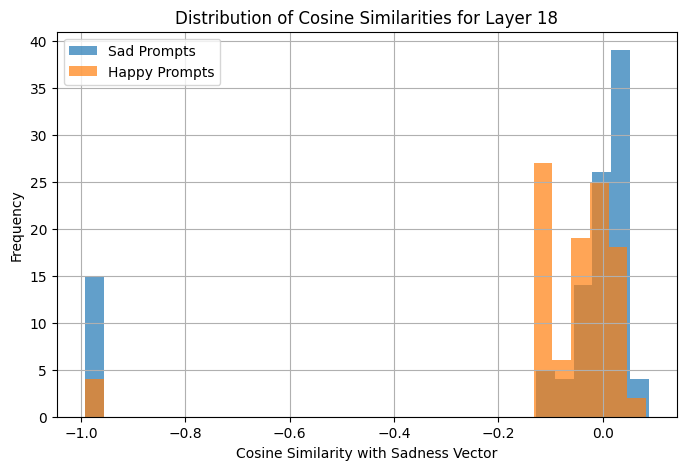

In [32]:
import torch.nn.functional as F
import matplotlib.pyplot as plt

def check_vector_alignment(sadness_vector, sad_activations, happy_activations):
    """Calculates cosine similarity to check vector alignment."""
    # Ensure vector is normalized for a clean cosine similarity interpretation
    sadness_vector_norm = sadness_vector / torch.linalg.norm(sadness_vector)

    # Cosine similarity between each sad activation and the sadness vector
    sad_sims = F.cosine_similarity(sad_activations, sadness_vector_norm.unsqueeze(0))
    
    # Cosine similarity between each happy activation and the sadness vector
    happy_sims = F.cosine_similarity(happy_activations, sadness_vector_norm.unsqueeze(0))
    
    print(f"Mean cosine similarity for SAD prompts: {sad_sims.mean().item():.4f}")
    print(f"Mean cosine similarity for HAPPY prompts: {happy_sims.mean().item():.4f}")
    
    separation_score = sad_sims.mean() - happy_sims.mean()
    print(f"Cosine Sim Separation (Sad - Happy): {separation_score.item():.4f}")
    
    # --- FIX IS HERE ---
    # Convert to float32 before converting to numpy for plotting
    sad_sims_for_plotting = sad_sims.to(torch.float32).cpu().numpy()
    happy_sims_for_plotting = happy_sims.to(torch.float32).cpu().numpy()
    
    # Let's also see the distribution
    plt.figure(figsize=(8, 5))
    plt.hist(sad_sims_for_plotting, bins=30, alpha=0.7, label='Sad Prompts')
    plt.hist(happy_sims_for_plotting, bins=30, alpha=0.7, label='Happy Prompts')
    plt.xlabel("Cosine Similarity with Sadness Vector")
    plt.ylabel("Frequency")
    plt.title(f"Distribution of Cosine Similarities for Layer {test_layer}")
    plt.legend()
    plt.grid(True)
    plt.show()

# --- Re-run the check ---
# (Assuming all variables from the previous step are still loaded)
test_layer = 18
sadness_vector = sadness_vectors[test_layer].to(device)
sad_acts_for_layer = sad_test_activations[test_layer].to(device)
happy_acts_for_layer = happy_test_activations[test_layer].to(device)

print(f"\n--- Checking Alignment of Vector from Layer {test_layer} ---")
check_vector_alignment(sadness_vector, sad_acts_for_layer, happy_acts_for_layer)